# Прогнозирование оттока клиентов

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель исследования** - построить модель с максимально большим значением метрики ROC-AUC (>0.85), которая будет прогнозировать отток клиентов.

Информация о клиентах будет получена из файлов `contract_new.csv`, `personal_new.csv`, `internet_new.csv`, `phone_new.csv`.

**План работы**

1. Изучение данных. 
2. Предобработка данных.
3. Разбиение выборки на тестовую и тренировочную.
4. Исследование трех моделей МО: логистическая регрессия, случайный лес, катбуст. Предварительно закодировав и отмасштабировав признаки, в зависимости от выбранной модели. Выбрать лучшую модель по метрике ROC-AUC.
5. Проверка качества лучшей модели на тестовой выборке.
6. Исследование важности признаков лучшей модели.
7. Отчет о проделанной работе.

## Изучение данных

In [1]:
!pip install -U scikit-learn

In [2]:
!pip install phik

In [3]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb

from phik import phik_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (f1_score, roc_auc_score, accuracy_score, recall_score, roc_curve, make_scorer, 
                            precision_score, confusion_matrix)
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from catboost.utils import get_confusion_matrix

r_state = 310723

In [5]:
# Сохраним файлы в переменные
contract_df = pd.read_csv('/datasets/contract_new.csv')
personal_df = pd.read_csv('/datasets/personal_new.csv')
internet_df = pd.read_csv('/datasets/internet_new.csv')
phone_df = pd.read_csv('/datasets/phone_new.csv')

**Исследуем таблицу contract_df с информацией о договорах**

In [6]:
# посмотрим на таблицу contract_df
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
# изучим общую информацию о датафрейме
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
# Выполним переименование столбцов
contract_df.columns = ['customer_id','begin_date','end_date',
                       'type','paperless_billing','payment_method','monthly_charges','total_charges']

In [9]:
# Приведем к числовому типу данных колонку total_charges, а колонки с датами к типу datetime
contract_df['total_charges'] = pd.to_numeric(contract_df['total_charges'], errors='coerce')

contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'], format='%Y-%m-%d')
contract_df['end_date'] = pd.to_datetime(contract_df['end_date'], format='%Y-%m-%d', errors='coerce')

In [10]:
# изучим общую информацию о датафрейме
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [11]:
# Исследуем типы оплаты
df = contract_df['type'].value_counts(dropna=False)
df

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

Больше половины абонентов выбирают помесячную оплату. Количество абонентов, выбирающих оплату сразу за год и два года примерно одинаковое.

In [12]:
# Исследуем типы платежей
df = contract_df['payment_method'].value_counts(dropna=False)
df

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

Самый популярный тип оплаты среди абонентов - электронный чек (33,6%).

In [13]:
# Исследуем расходы абонентов за месяц
contract_df[['monthly_charges']].describe()

,monthly_charges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


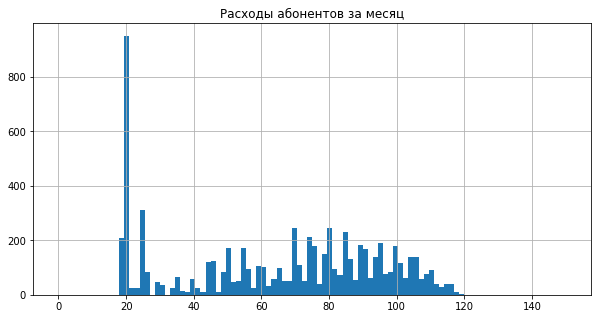

In [14]:
contract_df.hist('monthly_charges', bins=100, figsize=(10, 5), range=(0,150))
plt.title('Расходы абонентов за месяц')
plt.show()

На графике помесячных платежей наблюдается большое количество абонентов, оплачивающих 20 денежных едениц. Скорее всего, это какая-то типовая сумма, возможно, абонентская плата.

In [15]:
# Исследуем общие расходы абонентов
contract_df[['total_charges']].describe()

,total_charges
count,7032.000000
mean,2118.621822
std,2112.736199
min,19.050000
25%,439.745000
50%,1345.275000
75%,3239.317500
max,9221.380000


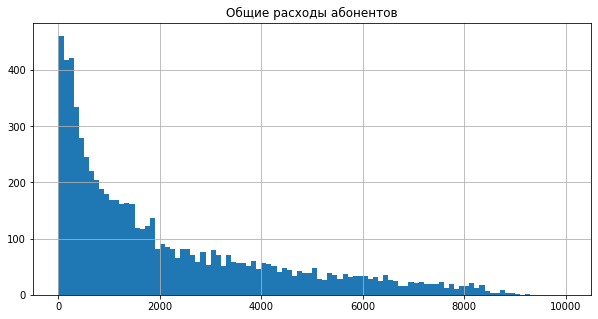

In [16]:
contract_df.hist('total_charges', bins=100, figsize=(10, 5), range=(0,10000))
plt.title('Общие расходы абонентов')
plt.show()

На графике общих расходов виден длинный хвост высоких значений. Большая часть абонентов потратила на услуги менее 2000.

In [17]:
# Исследуем даты начала договоров
contract_df[['begin_date']].describe()

,begin_date
count,7043
unique,77
top,2014-02-01 00:00:00
freq,366
first,2013-10-01 00:00:00
last,2020-02-01 00:00:00


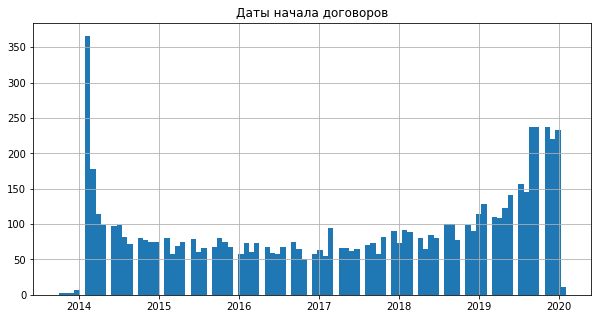

In [18]:
contract_df.hist('begin_date', bins=96, figsize=(10, 5))
plt.title('Даты начала договоров')
plt.show()

Большая часть договоров была заключена в начале 2014 года. Далее их количество почти не менялось год за годом. В 2019 году количество новых договоров начало расти.

In [19]:
# Исследуем даты окончания договоров
contract_df[['end_date']].describe()

,end_date
count,1101
unique,66
top,2020-01-01 00:00:00
freq,39
first,2014-06-01 00:00:00
last,2020-01-01 00:00:00


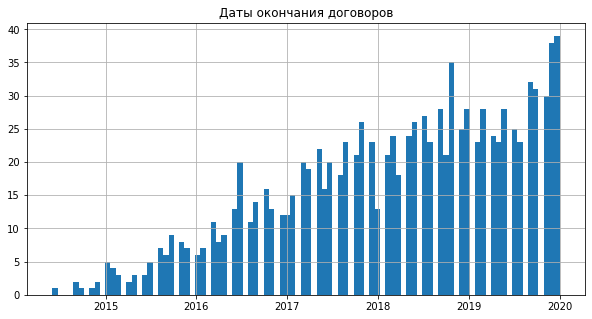

In [20]:
contract_df.hist('end_date', bins=96, figsize=(10, 5))
plt.title('Даты окончания договоров')
plt.show()

Количество абонентов, расторгающих договоры увеличивается с каждым годом. Что вполне закономерно, так как количество абонентов с каждым годом увеличивется.

**Исследуем таблицу personal_df с персональными данными клиентов**

In [21]:
# посмотрим на таблицу personal_df
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [22]:
# изучим общую информацию о датафрейме
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [23]:
# Выполним переименование столбцов
personal_df.columns = ['customer_id','gender','senior_citizen','partner','dependents']

In [24]:
# Исследуем пол абонентов
df = personal_df['gender'].value_counts(dropna=False)
df

Male      3555
Female    3488
Name: gender, dtype: int64

Пол абонентов распределился практически 50/50

In [25]:
# Исследуем количество пенсионеров среди абонентов
df = personal_df['senior_citizen'].value_counts(dropna=False)
df

0    5901
1    1142
Name: senior_citizen, dtype: int64

Среди абонентов присутствует 16,2% пенсионеров.

In [26]:
# Исследуем семейное положение абонентов
df = personal_df['partner'].value_counts(dropna=False)
df

No     3641
Yes    3402
Name: partner, dtype: int64

Количество абонентов в официальных супружеских отношениях и без также примерно одинаковое.

In [27]:
# Исследуем наличие детей у абонентов
df = personal_df['dependents'].value_counts(dropna=False)
df

No     4933
Yes    2110
Name: dependents, dtype: int64

Дети есть у 30% абонентов.

**Исследуем таблицу internet_df с информацией об интернет услугах**

In [28]:
# посмотрим на таблицу internet_df
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [29]:
# изучим общую информацию о датафрейме
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [30]:
# Выполним переименование столбцов
internet_df.columns = ['customer_id','internet_service','online_security','online_backup',
                       'device_protection','tech_support','streaming_tv','streaming_movies']

In [31]:
# Исследуем типы подключения интернета
df = internet_df['internet_service'].value_counts(dropna=False)
df

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

56% пользователей интернета выбирают подключение по оптоволоконному кабелю

**Исследуем таблицу phone_df с информацией об услугах телефонии**

In [32]:
# посмотрим на таблицу phone_df
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [33]:
# изучим общую информацию о датафрейме
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [34]:
# Выполним переименование столбцов
phone_df.columns = ['customer_id','multiple_lines']

**Вывод**

Исследованы 4 датафрейма с информацией о договорах, данных клиентов, интернет-услугах, услугах телефонии.
Всего имеем 7043 абонента в предоставленных данных. Услугами телефонии пользуется 6361 абонент, интернетом - 5517.
Столбца с целевым признаком нет. Его необходимо будет создать.

Был проведен исследовательский анализ данных. Выявлены следующие особенности:

- Больше половины абонентов выбирают помесячную оплату. Количество абонентов, выбирающих оплату сразу за год и два года примерно одинаковое.
- Самый популярный тип оплаты среди абонентов - электронный чек (33,6%).
- На графике помесячных платежей наблюдается большое количество абонентов, оплачивающих 20 денежных едениц.
- Большая часть абонентов потратила на услуги менее 2000.
- Большая часть договоров была заключена в начале 2014 года. Далее их количество почти не менялось год за годом. В 2019 году количество новых договоров начало расти.
- Количество абонентов, расторгающих договоры увеличивается с каждым годом. Что вполне закономерно, так как количество абонентов с каждым годом увеличивется.
- Количество абонентов в официальных супружеских отношениях и без также примерно одинаковое, таке как и количество мужчин и женщин среди абонентов.
- Среди абонентов присутствует 16,2% пенсионеров.
- Дети есть у 30% абонентов.
- 56% пользователей интернета выбирают подключение по оптоволоконному кабелю. Остальные по телефонной линии.

## Предобработка данных

In [35]:
# соберем все данные в одну таблицу
all_df = contract_df.merge(right=personal_df, on='customer_id', how='left')
all_df = all_df.merge(right=internet_df, on='customer_id', how='left')
all_df = all_df.merge(right=phone_df, on='customer_id', how='left')

In [36]:
# посмотрим на получившуюся таблицу
all_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [37]:
all_df.info() # выведем общую информацию о ней

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [38]:
all_df.duplicated().sum() # проверка на полные дубликаты

0

Полных дубликатов нет.

In [39]:
# посмотрим на количество пропусков
all_df.isna().sum()

customer_id             0
begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [40]:
# посмотрим на долю пропусков
pd.DataFrame(round(all_df.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
customer_id,0.000000
begin_date,0.000000
end_date,84.400000
type,0.000000
paperless_billing,0.000000
payment_method,0.000000
monthly_charges,0.000000
total_charges,0.200000
gender,0.000000
senior_citizen,0.000000


In [41]:
# Удалим 11 строк с пропусками в столбце total_charges
all_df = all_df.dropna(subset=['total_charges'])

Так как пропуски в большинстве столбцов означают, что абонент просто не использует данную услугу, то заполним их значением `No`.

In [42]:
all_df['internet_service'] = all_df['internet_service'].fillna('No_used')
all_df['online_security'] = all_df['online_security'].fillna('No')
all_df['online_backup'] = all_df['online_backup'].fillna('No')
all_df['device_protection'] = all_df['device_protection'].fillna('No')
all_df['tech_support'] = all_df['tech_support'].fillna('No')
all_df['streaming_tv'] = all_df['streaming_tv'].fillna('No')
all_df['streaming_movies'] = all_df['streaming_movies'].fillna('No')
all_df['multiple_lines'] = all_df['multiple_lines'].fillna('No')

In [43]:
# Создадим столбец с целевым признаком на основе столбца end_date. Если клиент ушел - 1, договор еще действует - 0.
all_df['gone'] = all_df['end_date'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [44]:
# Создадим столбец с продолжительностью договоров в днях
all_df['end_date'] = all_df['end_date'].fillna(pd.to_datetime('2020-02-01'))
all_df['duration'] = (all_df['end_date']-all_df['begin_date']).dt.days

Удалим столбцы с датами, чтобы предотвратить утечку данных и сделать модели МО более универсальными. Также удалим столбец с id пользователей, так как он бесполезен для обучения моделей.

In [45]:
all_df = all_df.drop(columns = ['begin_date', 'end_date', 'customer_id'], axis = 1) 

In [46]:
# Посмотрим на получившуюся таблицу после преобразований
all_df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gone,duration
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


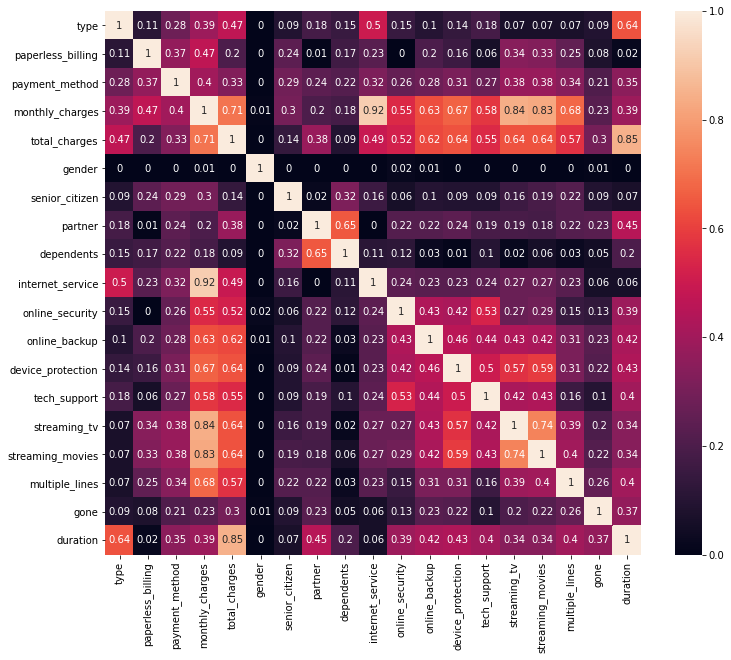

In [47]:
# построим тепловую карту корреляции признаков
numeric_features = ['monthly_charges', 'total_charges', 'duration']

corr_matrix = all_df.phik_matrix(numeric_features).round(2)

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

Наблюдается сильная зависимость между признаками `monthly_charges` и `internet_service`. Чтобы избавиться от мультиколлинеарности удалим один из признаков.

In [48]:
all_df = all_df.drop(columns = ['monthly_charges'], axis = 1) 

**Вывод**

Была проведена предварительная обработка данных: 
- Данные объеденены в один датафрейм
- Удалены 11 строк с пропусками в столбце total_charges
- Пропуски категориальных признаков заполнены значением No, так как отсутствие значений в этих признаках означает неиспользованием абонентом данной услуги.
- Для предотвращения утечки данных были удалены столбцы с датами. Также был удален столбец с id абонентов, в связи с неинформативностью.
- И удален столбец monthly_charges для предотвращения мультиколлинеарности.

## Подготовка данных к обучению моделей

Исследуем баланс классов в целевом признаке.

0    0.84343
1    0.15657
Name: gone, dtype: float64


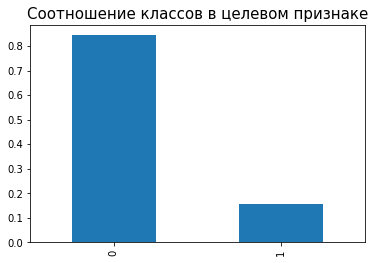

In [49]:
# посмотрим на соотношение классов в целевом признаке
class_frequency = all_df['gone'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 
plt.title('Соотношение классов в целевом признаке', fontsize=15)
plt.show()

В предоставленных данных 15.7% клиентов расторгли договор. Наблюдается дисбаланс классов.

In [50]:
# создадим переменные для признаков и целевого признака 
features = all_df.drop(['gone'], axis=1)
target = all_df['gone']

In [51]:
# Разделим данные на выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=r_state, stratify = target)

In [52]:
# Проверим размеры получившихся таблиц 
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((5274, 17), (1758, 17), (5274,), (1758,))

In [53]:
# Сбросим индексы
features_train.reset_index(drop=True, inplace=True)
features_test.reset_index(drop=True, inplace=True)
target_train.reset_index(drop=True, inplace=True)
target_test.reset_index(drop=True, inplace=True)

In [54]:
features_train.head()

,type,paperless_billing,payment_method,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration
0,Two year,Yes,Credit card (automatic),6002.70,Female,0,No,Yes,Fiber optic,Yes,No,Yes,Yes,No,No,Yes,2010
1,Month-to-month,Yes,Electronic check,921.02,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No,337
2,Month-to-month,Yes,Electronic check,409.32,Male,1,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,No,123
3,Month-to-month,No,Electronic check,1784.53,Male,1,Yes,No,Fiber optic,Yes,No,No,No,Yes,No,Yes,580
4,One year,Yes,Mailed check,1048.09,Female,0,No,No,Fiber optic,No,Yes,No,No,No,No,No,396


In [55]:
# Список столбцов, требующих кодирования
categorical_features = features_train.select_dtypes(include='object').columns.to_list()
print(categorical_features)

['type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


In [56]:
# Список столбцов, требующих масштабирования
numerical_features = ['total_charges', 'duration']

In [57]:
# Скопируем датафреймы с признаками для дальнейшего кодирования
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [58]:
# преобразуем категориальные признаки
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoder_ohe.fit(features_train_ohe[categorical_features])

features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohe[categorical_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_ohe = features_train_ohe.drop(categorical_features, axis=1)
features_train_ohe.head()

,total_charges,senior_citizen,duration,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,...,dependents_Yes,internet_service_Fiber optic,internet_service_No_used,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
0,6002.70,0,2010,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,921.02,1,337,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,409.32,1,123,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,1784.53,1,580,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1048.09,0,396,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# кодируем тестовые данные
features_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[categorical_features])
features_test_ohe = features_test_ohe.drop(categorical_features, axis=1)

In [60]:
# Стандартизируем данные 
scaler = StandardScaler()
scaler.fit(features_train_ohe[numerical_features])

features_train_ohe[numerical_features] = scaler.transform(features_train_ohe[numerical_features])
features_test_ohe[numerical_features] = scaler.transform(features_test_ohe[numerical_features])

In [61]:
features_train_ohe.head()

,total_charges,senior_citizen,duration,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,...,dependents_Yes,internet_service_Fiber optic,internet_service_No_used,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
0,1.846916,0,1.641146,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,-0.564925,1,-0.819566,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.807785,1,-1.134326,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,-0.155090,1,-0.462153,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.504616,0,-0.732787,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


**Вывод**

Исследование баланса классов показало, что есть дисбаланс, который может негативно сказаться на качестве моделей. Поэтому в моделях чувствительных к дисбалансу далее будем использовать метод взвешивания классов.

Для дальнейшего обучения моделей данные необходимо было преобразовать:
- применено OHE кодирование категориальных признаков,
- и StandardScaler для численных признаков

## Обучение моделей

**Логистическая регрессия**

In [62]:
model = LogisticRegression(random_state=r_state, class_weight='balanced')

# Сетка параметров
param_grid = {'C': [0.1, 1.0, 10.0, 100.0, 200.0],
              'penalty': ['l1', 'l2']}

# GridSearchCV с метрикой ROC-AUC
grid_search = GridSearchCV(model, param_grid, scoring=['roc_auc', 'recall', 'precision', 'f1'], refit='roc_auc', cv=5)

# Обучение модели и выполнение поиска по сетке
grid_search.fit(features_train_ohe, target_train)

best_model_log = grid_search.best_estimator_
best_params_log = grid_search.best_params_
best_score_log = grid_search.best_score_

In [63]:
# Вывод результатов
print("ROC-AUC лучшей модели: ", best_score_log)
print("recall лучшей модели:", grid_search.cv_results_['mean_test_recall'][grid_search.best_index_])
print("precision лучшей модели:", grid_search.cv_results_['mean_test_precision'][grid_search.best_index_])
print("f1 лучшей модели:", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
print("Лучшие параметры: ", best_params_log)

ROC-AUC лучшей модели:  0.7799541307505777
recall лучшей модели: 0.6889156626506023
precision лучшей модели: 0.3143797535450942
f1 лучшей модели: 0.43153152893059266
Лучшие параметры:  {'C': 100.0, 'penalty': 'l2'}


**Случайный лес**

In [101]:
model = RandomForestClassifier(random_state=r_state, class_weight='balanced')

# Сетка параметров
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [4, 5, 7, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV с метрикой ROC-AUC
grid_search = GridSearchCV(model, param_grid, scoring=['roc_auc', 'recall', 'precision', 'f1'], refit='roc_auc', cv=5)

# Обучение модели и выполнение поиска по сетке
grid_search.fit(features_train_ohe, target_train)

best_model_rf = grid_search.best_estimator_
best_params_rf = grid_search.best_params_
best_score_rf = grid_search.best_score_

In [102]:
# Вывод результатов
print("Метрика лучшей модели: ", best_score_rf)
print("recall лучшей модели:", grid_search.cv_results_['mean_test_recall'][grid_search.best_index_])
print("precision лучшей модели:", grid_search.cv_results_['mean_test_precision'][grid_search.best_index_])
print("f1 лучшей модели:", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
print("Лучшие параметры: ", best_params_rf)

Метрика лучшей модели:  0.8287914522609802
recall лучшей модели: 0.4915516611902154
precision лучшей модели: 0.47087170990261995
f1 лучшей модели: 0.4805915129431952
Лучшие параметры:  {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 500}


**Catboost**

In [69]:
model = CatBoostClassifier(random_state=r_state, cat_features=categorical_features)

# Определение сетки параметров
param_grid = {
    'depth': [4,6,8],
    'iterations': [100, 500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

grid_search = GridSearchCV(model, param_grid, scoring=['roc_auc', 'recall', 'precision', 'f1'], refit='roc_auc', 
                           cv=3)

# Обучение модели и выполнение поиска по сетке
grid_search.fit(features_train, target_train, verbose_eval=False)

best_model_cb = grid_search.best_estimator_
best_params_cb = grid_search.best_params_
best_score_cb = grid_search.best_score_

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [69]:
# Вывод результатов
print("Метрика лучшей модели: ", best_score_cb)
print("recall лучшей модели:", grid_search.cv_results_['mean_test_recall'][grid_search.best_index_])
print("precision лучшей модели:", grid_search.cv_results_['mean_test_precision'][grid_search.best_index_])
print("f1 лучшей модели:", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
print("Лучшие параметры: ", best_params_cb)

Метрика лучшей модели:  0.9232541052481169
recall лучшей модели: 0.6175027382256297
precision лучшей модели: 0.8889249196923836
f1 лучшей модели: 0.7284054132400147
Лучшие параметры:  {'depth': 4, 'iterations': 1500, 'learning_rate': 0.1}


In [70]:
# Соберем в сводную таблицу данные 
results = [
    ['LogisticRegression', 0.779, 0.687, 0.314, 0.431], 
    ['RandomForestClassifier', 0.828, 0.491, 0.470, 0.480],
    ['CatBoostClassifier', 0.923, 0.617, 0.889, 0.728]
]

columns = ['model','ROC-AUC', 'recall', 'precision', 'f1']

balanced_result = pd.DataFrame(data=results, columns=columns)
balanced_result

,model,ROC-AUC,recall,precision,f1
0,LogisticRegression,0.779,0.687,0.314,0.431
1,RandomForestClassifier,0.828,0.491,0.470,0.480
2,CatBoostClassifier,0.923,0.617,0.889,0.728


**Вывод**

Лучший результат показала модель Catboost с гиперпараметрами - 'depth': 4, 'iterations': 1500, 'learning_rate': 0.1.
И значением метрики ROC-AUC 0.923.
Возьмем данную модель для проверки на тестовых данных.

## Проверка на тестовых данных

In [103]:
probabilities_test = best_model_cb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('ROC-AUC:', auc_roc)

ROC-AUC: 0.9270459143014773


## Исследование важности признаков лучшей модели

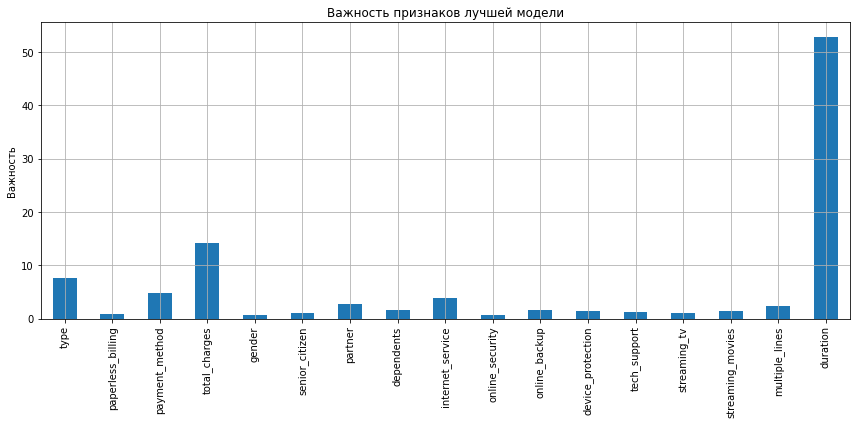

In [73]:
feature_importance_cb = best_model_cb.get_feature_importance()
feature_importance_cb = pd.Series(feature_importance_cb, index=features_test.columns)

plt.show()

fig, ax = plt.subplots(figsize=(12,6))

feature_importance_cb.plot.bar(ax=ax, grid=True)
ax.set_title("Важность признаков лучшей модели")
ax.set_ylabel('Важность')
fig.tight_layout()

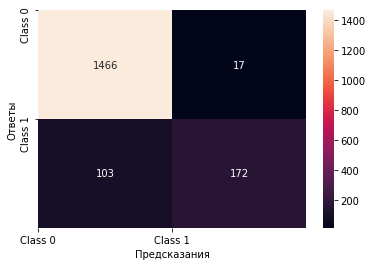

In [108]:
# Построим матрицу ошибок лучшей модели
cm = get_confusion_matrix(best_model_cb, cb.Pool(features_test, target_test, cat_features=categorical_features))

# Создание тепловой карты для матрицы ошибок
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Предсказания')
plt.ylabel('Ответы')
plt.xticks(np.arange(2), ['Class 0', 'Class 1'])
plt.yticks(np.arange(2), ['Class 0', 'Class 1'])
plt.show()

**Вывод**

На тестовых данных модель Catboost показала такой же высокий результат как и на тренировочных данных с метрикой ROC-AUC 0.927.

Также была исследована важность признаков лучшей модели. Наиболее важными оказались признаки - duration, total_charges, type, payment_method и internet_service.

Исследование матрицы ошибок показало, что модель предсказала 172 истинно положительных ответа. Этот показатель является наиболее важным для задач бизнеса, чтобы он мог предпринять действия для удержания клиента. Также модель дала 103 ложноотрицательных и 17 ложноположительных ответов.

## Отчет о проделанной работе

План работы, который был составлен изначально:

1. Изучение данных. 
2. Предобработка данных.
3. Разбиение выборки на тестовую и тренировочную.
4. Исследование трех моделей МО: логистическая регрессия, случайный лес, катбуст. Предварительно закодировав и отмасштабировав признаки, в зависимости от выбранной модели. Выбрать лучшую модель по метрике ROC-AUC.
5. Проверка качества лучшей модели на тестовой выборке.
6. Исследование важности признаков лучшей модели.
7. Отчет о проделанной работе.

Все пункты плана были выполнены в соответствии со списком. 
Трудностей в ходе работы не возникло.

Ключевыми шагами можно выделить:
- Предобработку данных.
- Подбор гиперпараметров моделей с помощью GridSearchCV.
- Проверку лучшей модели на тестовой выборке.

Для решения задачи классификации были построены три модели машинного обучения: логистическая регрессия, случайный лес, Catboost. Их качество оценивалось по метрике ROC-AUC.

***Лучшее качество по метрике ROC-AUC на тренировочной выборке показала модель Catboost с гиперпараметрами 'depth': 4, 'iterations': 1500, 'learning_rate': 0.1. Значение ROC-AUC = 0.923.*** Дополнительно были исследованы метрики модели: f1 = 0.728, recall = 0.617, precision = 0.889. 

Также на тестовой выборке было проверено качество выбранной лучшей модели. ***Метрика на тестовой выборке ROC-AUC = 0.927.***

Модель обучалась на следующих признаках:

- `type` - тип оплаты: раз в год-два или ежемесячно;
- `paperless_billing` - электронный расчётный лист;
- `payment_method` -  тип платежа;
- `total_charges` - общие расходы абонента;
- `gender` - пол;
- `senior_citizen` - является ли абонент пенсионером;
- `partner` - есть ли у абонента супруг или супруга;
- `dependents` - есть ли у абонента дети;
- `internet_service` -  тип подключения;
- `online_security` - блокировка опасных сайтов;
- `online_backup` - облачное хранилище файлов для резервного копирования данных;
- `device_protection` - антивирус;
- `tech_support` - выделенная линия технической поддержки;
- `streaming_tv` - стриминговое телевидение;
- `streaming_movies` - каталог фильмов;
- `multiple_lines` - подключение телефона к нескольким линиям одновременно;
- `duration` - длительность действия договора с абонентом в днях.
- `gone` - целевой признак.

Была проведена их предварительная обработка:

- Данные объеденены в один датафрейм.
- Удалены 11 строк с пропусками в столбце `total_charges`
- Созданы признаки `duration` - длительность действия договора с абонентом в днях и `gone` - целевой признак, в котором 1 означает уход абонента, а 0 - что договор с клиентом еще действует.
- Пропуски категориальных признаков заполнены значением No, так как отсутствие значений в этих признаках означает неиспользованием абонентом данной услуги.
- Для предотвращения утечки данных были удалены столбцы с датами. Также был удален столбец с id абонентов, в связи с неинформативностью.
- И удален столбец `monthly_charges` для предотвращения мультиколлинеарности.

Разбиение данных на выборки произведилось со стратификацией и соотношением тренировочных данных к тестовым 75:25. 
Также была исследована важность признаков лучшей модели. Наиболее важными оказались признаки - duration, total_charges, type, payment_method и internet_service.

Задача, поставленная в начале исследования, выполнена. Удалось достичь значение метрики ROC-AUC >0.85.

Можно ли еще улучшить модель? 
- Да, можно поэкспериментировать с признаками: создать новые фичи на основе имеющихся данных, удалить малозначимые признаки и заполнить пропуски другими методами.
- Можно попробовать обучить другие модели. Например, модели LGBM и XGBoost.